In [255]:
from __future__ import annotations
import networkx as nx
import matplotlib.pyplot as plt
from celluloid import Camera
from dataclasses import dataclass
from typing import Union, Self, Callable, List, Optional
from random import randint, choice
from math import inf
from queue import PriorityQueue

In [256]:
GRAPH_SEED: int = 1
DRAWING_SEED: int = 1
DIRECTED_GRAPH: bool = False
GRAPH_SIZE: int = 8
EDGE_PROBABILITY: float = 0.5

In [257]:
@dataclass
class FunctionOutput:
    visited: list
    parents: dict
    
    def __repr__(self) -> str:
        return "".join([f"{parent} -> {node}\n" for node, parent in self.parents.items()])

In [258]:
class GraphFunctions:
    @staticmethod
    def cost(g: nx.Graph, node1: int, node2: int) -> float:
        return g.get_edge_data(node1,node2).get('weight')

    @staticmethod
    def get_edges(g: nx.Graph, node: int, mst) -> list[tuple[int, float]]:
        return list((n2 if n1==node else n1, g.edges()[n1,n2]["weight"]) for n1, n2 in g.edges(node) if not (n2 in mst and n1 in mst))

    @staticmethod
    def find_min_edge(edges) -> tuple[int, float]:
        min_edge = (None, inf)
        for edge in edges:
            if edge[1] < min_edge[1]:
                min_edge = edge
        return min_edge
    
    @staticmethod
    def draw(g: nx.graph, node_colors: Union[List[str], None]=None) -> None:
        node_colors = node_colors or ['white' for node in g.nodes()]
        elarge = [(u, v) for (u, v, d) in g.edges(data=True) if d["weight"] > 0.5]
        esmall = [(u, v) for (u, v, d) in g.edges(data=True) if d["weight"] <= 0.5]
        #pos = nx.spring_layout(self.g, seed=DRAWING_SEED)
        pos = nx.shell_layout(g)
        nx.draw_networkx_nodes(g, pos, node_size=700, node_color=node_colors)
        nx.draw_networkx_edges(g, pos, edgelist=elarge, width=3)
        nx.draw_networkx_edges(
            g, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="b", style="dashed"
        )
        nx.draw_networkx_labels(g, pos, font_size=20, font_family="sans-serif")
        edge_labels = nx.get_edge_attributes(g, "weight")
        nx.draw_networkx_edge_labels(g, pos, edge_labels)
        ax = plt.gca()
        ax.margins(0.08)
        plt.axis("off")
        plt.tight_layout()
        
    @staticmethod
    def draw_function(g: nx.graph, start: int, function_to_draw: Callable [[nx.Graph, int], FunctionOutput], end: Optional[int]=None) -> None:
            fig = plt.figure()
            camera = Camera(fig)
            function_ouput = function_to_draw(start, end)
            if function_ouput is None:
                raise Exception("Function output is None")
            tmp = []
            for i in function_ouput.visited:
                tmp.append(i)
                colors = ['r' if node in tmp else 'white' for node in g.nodes() ]
                GraphFunctions.draw(g, node_colors=colors)
                camera.snap()
            camera.animate().save(f'{function_to_draw.__name__}.gif', writer='imagemagick', fps=1)
            return function_ouput

In [259]:
class Graph:
    def __init__(self, g: Union[nx.Graph, None]=None) -> None:
        if g is None:
            self.g: nx.Graph = nx.Graph()
        else:
            self.g: nx.Graph = g

    @classmethod
    def create_example_graph(cls: type[Graph]) -> Graph:
        g = nx.erdos_renyi_graph(GRAPH_SIZE, EDGE_PROBABILITY, seed=GRAPH_SEED, directed=DIRECTED_GRAPH)
        for (u, v) in g.edges():
            g.edges[u,v]['weight'] = randint(1,10)
            try:
                g.edges[v,u]['weight'] = g.edges[u,v]['weight']
            except KeyError:
                pass
        return cls(g)

    
    def bfs(self, start: int, end:Optional[int]=None) -> FunctionOutput:
        queue: list = [start]
        visited: list = [start]
        parents: dict = {}
        while queue:
            print(f"Queue: {queue}")
            node: int = queue.pop(0)
            if node == end:
                break
            print(f"Current node: {node}")
            for neighbour in self.g.neighbors(node):
                if neighbour not in visited:
                    visited.append(neighbour)
                    parents[neighbour] = node
                    queue.append(neighbour)
        return FunctionOutput(visited, parents)
    

    def dfs(self, start: int, end:Optional[int]=None) -> FunctionOutput:
        visited = []
        parents = {}
        Graph.dfs_recursion(self.g, start, visited, parents)
        print(visited)
        print(parents)
        return FunctionOutput(visited, parents)
    
    @staticmethod
    def dfs_recursion(g: nx.Graph, start: int, visited: list, parents: dict) -> FunctionOutput:
        visited.append(start)
        print(f"Visited: {visited}")
        print(f"Current node: {start}")
        for node in g.neighbors(start):
            if node not in visited:
                parents[node] = start
                Graph.dfs_recursion(g, node, visited, parents)
    
    
    def djikstra(self: Self, start: int, end:Optional[int]=None) -> Optional[FunctionOutput]:
        prev = {v: -1 for v in self.g.nodes()}
        dist = {v: inf for v in self.g.nodes()}
        dist[start] = 0
        pq = PriorityQueue()
        for node, value in dist.items():
            pq.put((value, node))
        while pq.queue:
            current_dist, node = pq.get()
            for neighbour in self.g.neighbors(node):
                if neighbour not in [x[1] for x in pq.queue]:
                    continue
                path = current_dist + GraphFunctions.cost(self.g, node, neighbour)
                if path < dist[neighbour]:
                    print(f"Found new path to {neighbour} with cost {path}")
                    pq.queue.remove((dist[neighbour],neighbour))
                    pq.put((path, neighbour))
                    dist[neighbour] = path
                    prev[neighbour] = node
        for key in dist.keys():
            print(f"for {key}, cost: {dist[key]} from {prev[key]}")
        
        if end is not None:
            visited = [end]
            parents = {}
            while visited[-1] != start:
                visited.append(prev[visited[-1]])
                parents[visited[-2]] = visited[-1]
            parents = {k: v for k, v in reversed(parents.items())}
            return FunctionOutput(visited[::-1], parents)

    def floyd(self: Self, start: int, end:Optional[int]=None) -> dict:
        dist = [[inf for _ in self.g.nodes()] for _ in self.g.nodes()]
        print(dist)
        pass



    #def prim(self, start: int) -> None:
    #    if DIRECTED_GRAPH:
    #        raise Exception("Prim's algorithm can only be used on undirected graphs")
    #    mst = list()
    #    edges = GraphFunctions.get_edges(self.g, start, mst)
    #    mst.append(start)
    #    while len(mst) < len(self.g.nodes()):
    #        min_edge, min_weight = GraphFunctions.find_min_edge(edges)
    #        mst.append(min_edge)
    #        edges += GraphFunctions.get_edges(self.g, min_edge, mst)
    #        edges.remove((min_edge, min_weight))
    #    return FunctionOutput(mst, {})

In [260]:
graph = Graph.create_example_graph()

Queue: [0]
Current node: 0
Queue: [1, 4, 5, 6]
Current node: 1
Queue: [4, 5, 6, 3]
Current node: 4
Queue: [5, 6, 3, 2, 7]
Current node: 5
Queue: [6, 3, 2, 7]
Current node: 6
Queue: [3, 2, 7]


MovieWriter imagemagick unavailable; using Pillow instead.


0 -> 1
0 -> 4
0 -> 5
0 -> 6
1 -> 3
4 -> 2
4 -> 7

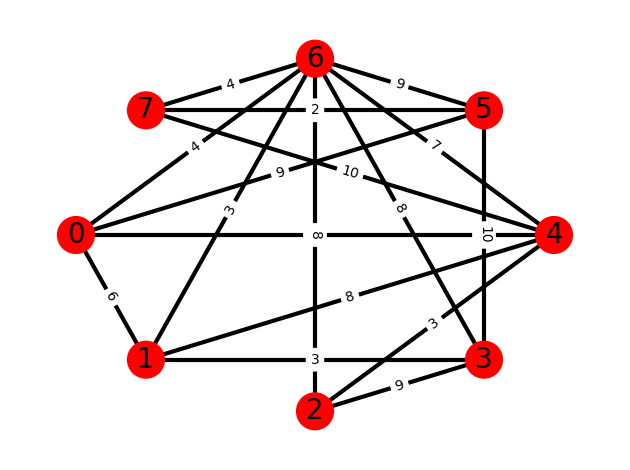

In [261]:
GraphFunctions.draw_function(graph.g, 0, graph.bfs, 3)

In [262]:
#GraphFunctions.draw_function(graph.g, 0, graph.dfs)

In [263]:
GraphFunctions.draw_function(graph.g, 0, graph.djikstra, end=3)

Found new path to 1 with cost 6
Found new path to 4 with cost 8
Found new path to 5 with cost 9
Found new path to 6 with cost 4
Found new path to 2 with cost 12
Found new path to 3 with cost 12
Found new path to 7 with cost 8
Found new path to 3 with cost 9
Found new path to 2 with cost 11
for 0, cost: 0 from -1
for 1, cost: 6 from 0
for 2, cost: 11 from 4
for 3, cost: 9 from 1
for 4, cost: 8 from 0
for 5, cost: 9 from 0
for 6, cost: 4 from 0
for 7, cost: 8 from 6


TypeError: cannot convert dictionary update sequence element #0 to a sequence

<Figure size 640x480 with 0 Axes>